In [178]:
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import random

from scipy import eye, asarray, dot, sum, diag
from scipy.linalg import svd
from mpl_toolkits.basemap import Basemap
import matplotlib as mpl
from matplotlib import cm
from colorspacious import cspace_converter
from collections import OrderedDict
from netCDF4 import Dataset
from numpy import linspace
from numpy import meshgrid


import PCA_functions as pf
import Extreme_functions as ef

from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr, CMIknn
import tigramite.data_processing as pp

from Data import Data
from datetime import datetime

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

import itertools
from collections import Counter
import pickle

from numpy import linalg as LA

import matplotlib.cm as cm

from scipy.special import inv_boxcox
from scipy import stats

from matplotlib import animation

import scipy.stats as st

import reverse_geocoder as rg

from pandas_datareader import wb
import scipy.stats as st

import Rung as rung

from pandas_datareader import wb

import seaborn as sns


import seaborn as sns
import feature_finder_keiko as ff
import feature_finder_f as ff1

from scipy import signal

plt.rcParams["figure.figsize"] = (20,10)

In [343]:
step = 1
train_start = np.arange(1948,1977,step)
validation_end = np.arange(1982,2011,step)
test_start = np.arange(1983,2012,step)
test_end = np.arange(1987,2016,step)

n_components_sst = np.load("sst_number.npy")

tau = 12
f = 12
level = 99
extremes_treshold = -1

In [366]:
test_start[ijz]

2010

In [344]:
ijz = -2
temporal_limits = {"time_min":datetime(train_start[ijz], 1, 1, 0, 0),"time_max":datetime(validation_end[ijz], 12, 1, 0, 0)}
original_count, count = ff.drought_timeseries("ET_gamma_18912015_12.npy",train_start[ijz],validation_end[ijz],extremes_treshold = extremes_treshold)
data_sst, ts, V, df_sst, avg, std = ff.PCA_computer_rotated('../../../nc/sst.mnmean.nc', "sst",temporal_limits, n_components_sst[ijz], -9.96921e+36)

In [345]:
temporal_limits = {"time_min":datetime(test_start[ijz], 1, 1, 0, 0),"time_max":datetime(test_end[ijz], 12, 1, 0, 0)}
original_count_test, count_test = ff.drought_timeseries("ET_gamma_18912015_12.npy",test_start[ijz],test_end[ijz],extremes_treshold = extremes_treshold)
data_sst_test = ff.data_generator_avg_std('../../../nc/sst.mnmean.nc', "sst",temporal_limits, avg, std, 12, -9.96921e+36)

In [346]:
link  = np.load("../../whole_data_results/ET_orac/best_link_{}/pcmci_{}_{}_{}_{}_{}.npy".format(abs(extremes_treshold),f,train_start[ijz],validation_end[ijz],tau,n_components_sst[ijz]))

In [347]:
start_lag = tau
end_lag = tau+11

df = pd.DataFrame({"drought": original_count})
lags = np.arange(start_lag,end_lag + 1)
df = df.assign(**{
'{} (t-{})'.format(col, t): df[col].shift(t)
for t in lags
for col in df
})
for k in range(len(link)):
    df[str(k)] = ff.time_series_maker_V(data_sst, V[:,link[k,0]-1])
    df[str(k)] = df[str(k)].shift(abs(link[k,1]))
df = df.dropna()

x_train = df.iloc[:,1:]
y_train = df.iloc[:,0]

In [348]:
start_lag = tau
end_lag = tau + 11

df_test = pd.DataFrame({"drought":original_count_test})
lags = np.arange(start_lag,end_lag + 1)
df_test = df_test.assign(**{
'{} (t-{})'.format(col, t): df_test[col].shift(t)
for t in lags
for col in df_test
})
for k in range(len(link)):
    df_sst["pc"] = V[:,link[k,0]-1]
    df_test[str(k)] = ff.time_series_maker(link[k,0]-1, df_sst, data_sst_test)
    #df_test[str(k)] = ff.time_series_maker_V(data_sst_test, V[:,link[k,0]-1])
    df_test[str(k)] = df_test[str(k)].shift(abs(link[k,1]))
df_test = df_test.dropna()

x_test = df_test.iloc[:,1:]
y_test = df_test.iloc[:,0]

# Linear Regression

In [349]:
from sklearn.linear_model import LinearRegression

In [350]:
reg = LinearRegression().fit(x_train, y_train)
y_pred = reg.predict(x_test)

In [351]:
mean_squared_error(y_pred,y_test)

2569.0566615174707

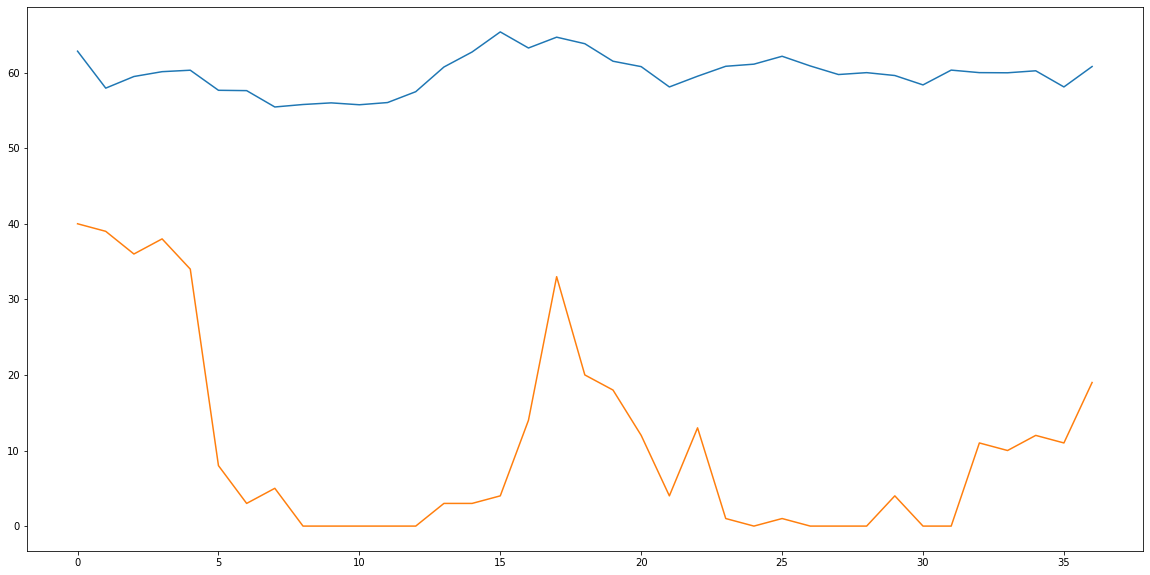

In [352]:
x = range(len(y_pred))
plt.plot(x,y_pred,x,y_test)

# Random Forest

In [353]:
regr = RandomForestRegressor(max_depth=10, random_state=0, n_estimators=1000)
regr.fit(x_train, y_train)
y_pred = regr.predict(x_test)

In [354]:
mean_squared_error(y_pred,y_test)

2873.8398470067837

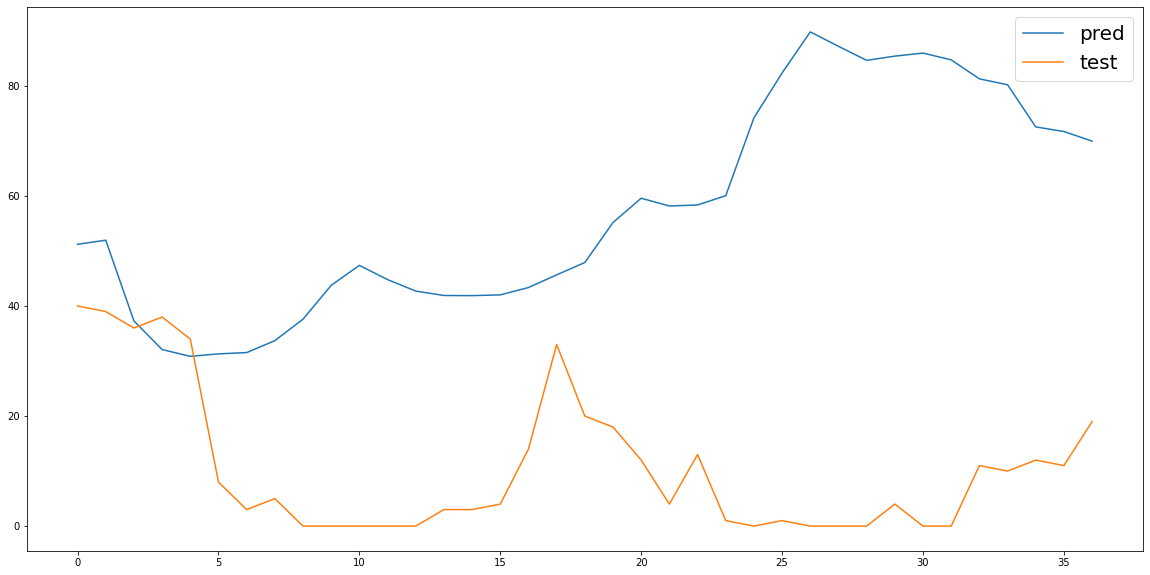

In [355]:
x = range(len(y_pred))
plt.plot(x,y_pred,label = 'pred')
plt.plot(x,y_test, label = 'test')
plt.legend(fontsize=20)

In [356]:
from xgboost import XGBRegressor

In [357]:
model = XGBRegressor(n_estimators=500, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
model.fit(x_train,y_train)
y_pred = model.predict(x_test)

In [358]:
mean_squared_error(y_pred,y_test)

2773.0244405971384

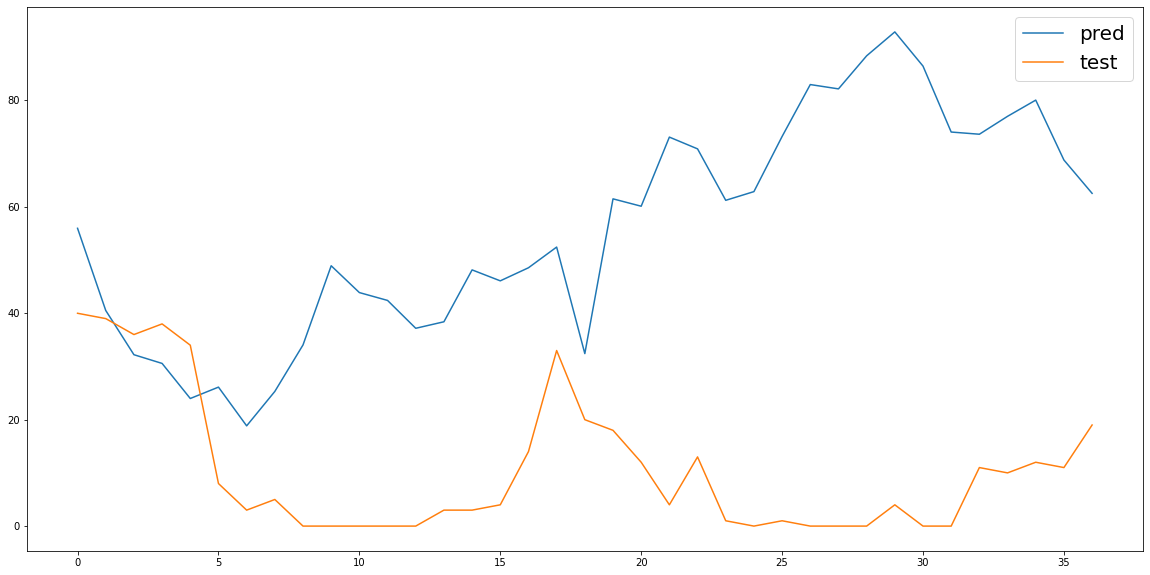

In [359]:
x = range(len(y_pred))
plt.plot(x,y_pred,label = 'pred')
plt.plot(x,y_test, label = 'test')
plt.legend(fontsize=20)

# KNN

In [360]:
from sklearn.neighbors import KNeighborsRegressor

In [361]:
neigh = KNeighborsRegressor(n_neighbors=9)
neigh.fit(x_train, y_train)

KNeighborsRegressor(n_neighbors=9)

In [362]:
y_pred = neigh.predict(x_test)

In [363]:
mean_squared_error(y_pred,y_test)

4285.599265932599

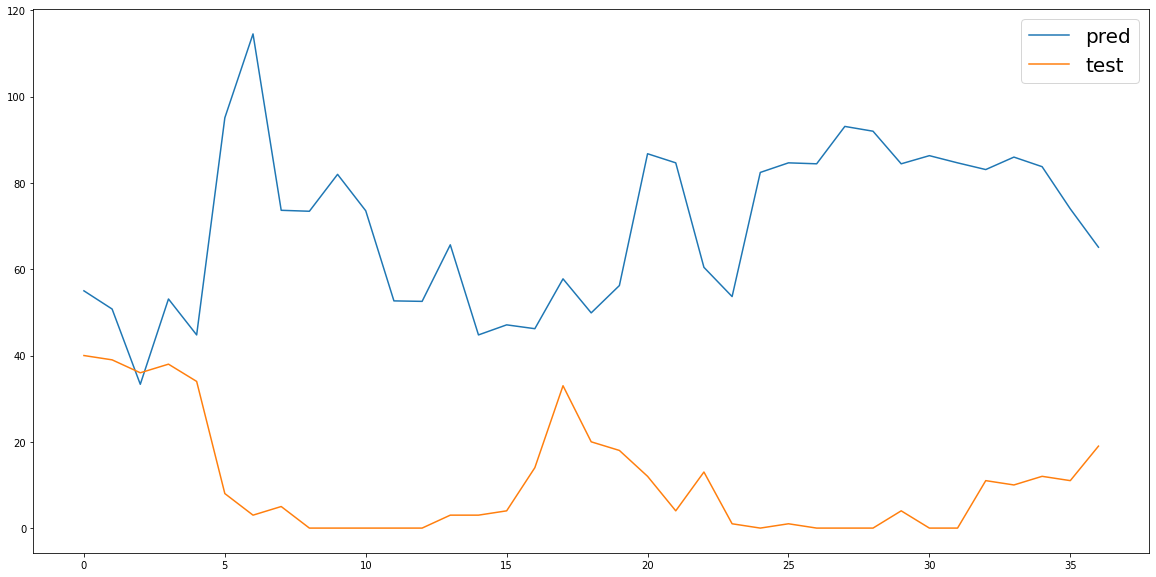

In [364]:
x = range(len(y_pred))
plt.plot(x,y_pred,label = 'pred')
plt.plot(x,y_test, label = 'test')
plt.legend(fontsize=20)